<a href="https://colab.research.google.com/github/KingNook/QCES/blob/main/Project2_transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/KingNook/QCES/blob/main/Project2_transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Tracer transport

A critical aspect of understanding climate and environmental systems is describing the movement of substances. This could include pollution or water vapor in the atmosphere, salt in an estuary, or chemicals in a river. We often model the transport of these substances using an advection/diffusion equation for the concentration of the substance. In this context, we sometimes refer to the concentration field as a `tracer' since it helps us track the movement of individual molecules. We can also use this framework to describe the transport of heat, although in this case the tracer field (temperature or heat content) tracks the movement of thermal energy.

In this project we will use Dedalus to solve advection diffusion equations to describe the vertical distribution of heat in the ocean and the concentration of pollution in a river.

Student tasks are in [Section 1.4](#section1pt4), [Section 1.6](#section1pt6), and [Section 2.3](#section2pt3)

## Setup
If you are using Google colab, run the script below to install Dedalus

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus already installed :)


## 1. Thermal structure in the ocean

Most of the ocean has a stable thermal stratification with warm water at the surface and cold water in the abyss (exceptions occur in salt-stratified waters like the Arctic Ocean). Since the ocean is a massive thermal reservoir, understanding the distribution of this heat is important to quantifying the ocean's role in a changing climate. The structure of the temperature field can also inform us about the circulation in the ocean interior.


### 1.1 Measured temperature profile

The code below plots a sample temperature profile obtained off the coast of California. The data was obtained by digitizing Figure 3 in Munk, 1966.

In [ ]:
import matplotlib.pyplot as plt

# Temperature measurements extracted from Figure 3 in Munk, 1966
CTD_T = [1.1296296296296295, 1.122004357298475, 1.1143790849673203, 1.1067538126361656, 1.1143790849673203, 1.1143790849673203, 1.1372549019607843, 1.122004357298475, 1.1372549019607843, 1.1525054466230937, 1.2287581699346406, 1.2745098039215685, 1.343137254901961, 1.4041394335511983, 1.526143790849673, 1.6405228758169934, 1.8997821350762527, 2.242919389978214, 2.69281045751634, 3.104575163398693, 3.104575163398693, 3.218954248366013, 3.4324618736383443, 3.8289760348583877, 4.042483660130719, 4.438997821350762]
CTD_z = [-4976.958525345623, -4869.431643625192, -4677.419354838709, -4470.046082949309, -4270.353302611367, -4070.6605222734256, -3932.411674347158, -3786.4823348694317, -3586.78955453149, -3394.7772657450078, -3195.084485407066, -2995.3917050691243, -2803.379416282642, -2580.6451612903224, -2350.230414746544, -2112.1351766513058, -1843.3179723502303, -1597.5422427035332, -1344.0860215053763, -1144.3932411674346, -1144.3932411674346, -1121.351766513057, -990.7834101382491, -821.8125960061443, -698.9247311827958, -583.7173579109067]

plt.scatter(CTD_T,CTD_z,s=10)
plt.xlabel('T (ºC)')
plt.ylabel('Depth (m)')


### 1.2 Abyssal recipes

Munk (1966) proposed that the thermal structure of the ocean interior is set by a balance between upwelling and diffusion. In this view, cold waters sink near the poles and spread across the seafloor before slowly rising through the ocean interior. If we assume, as Munk did, that the water upwells uniformly across the globe, the upwelling speed is approximately $10^{-7}$ m/s. This is far too small to directly measure, but it is large enough to have a major impact on the distribution of tracers. Since light can only penetrate through the top ~100m of ocean, we can ignore solar heating, except in that it sets the temperature near the ocean surface.

### 1.3 Steady advection/diffusion equation

Dedalus can solve differential equations in various forms. In addition to time-dependent initial value problems (IVPs), Dedalus can solve linear and nonlinear boundary value problems. The code below uses Dedalus to solve a linear boundary value problem (IVBP) for the steady state advection/diffusion equation.

Here, the top and bottom temperature are set from the measured profile and these are used as boundary conditions. The vertical (upwelling) velocity is set to $10^{-7} m/s$, and the diffusivity is set to $10^{-7}$ $m^2/s$, to approximate the molecular diffusivity of heat in seawater.

In [ ]:
"""
Dedalus script to solve the steady advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the upwelling velocity
w = 1e-7 # m/s
# Set the diffusivity
kappa = 1e-4 # 1e-7 # m^2/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - kappa*Tzz = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.4 Student investigation
<a id='section1pt4'></a>
Note that the profile above is not a good fit to the data. This implies that molecular diffusion isn't sufficient to transport heat down from the surface and stop the ocean from filling up with cold, dense water.

Munk (1966) proposed that small-scale turbulence in the ocean interior results in a diffusivity that is orders of magnitude larger than the molecular value. Find a diffusivity that gives a good match with the data and test it in the Dedalus script above. Comment on the ability of this model (steady advection/diffusion) to fit the data.

**Steady Advection / Diffusion**

Through the extremely rigorous process of guessing numbers, we see that choosing $\kappa\approx 1e-4$ gives a reasonably good fit to the data (ie setting the diffusivity to around 3 orders of magnitude larger than the molecular diffusivity).

This model fits the data reasonably well for 'shallower' waters (from around -1500m upwards), but consistently predicts a higher temperature for lower depths. In particular, we see the Temperature is nearly constant from around -3800m downwards which the model does not capture at all.

### 1.5 Turning ocean mixing upside down

Decades of research to measure the turbulent diffusivity in the ocean consistently found values much smaller than the one predicted by Munk (1966). Specifically, while larger values of the turbulent diffusivity were found near the bottom of the ocean over rough topographic features, the values in the upper ocean were about 10x smaller than the values predicted by Munk. 50 years after Munk's seminal paper, Ferrari et al. (2016) proposed that a depth-dependent turbulent diffusivity could be balanced by <em>downwelling</em>, with negative vertical velocities in the ocean interior. In this theory, the overturning circulation is upwelling in thin boundary layers along the sloping sides of the ocean basins.

When the diffusivity, $\kappa$, is a function of $z$, the steady advection/diffusion equation can be written

$$ w\frac{dT}{dz} = \frac{d}{dz}\left(\kappa(z) \frac{dT}{dz}\right)$$

The Dedalus script below solves the previous equation and again compares the results with the observed temperature profile. For the depth-dependent diffusivity, $\kappa(z)$, we take

$$ \kappa(z)=\kappa_{bg} + (\kappa_0-\kappa_{bg})e^{-(z+D)/l} $$

using the form from Rogers et al., 2023, where $\kappa_{bg}=1\times 10^{-5} m^2/s$ is the background diffusivity characteristic of the upper water column, $\kappa_0=8.6\times 10^{-4} m^2/s$ characterizes the enhanced mixing near the bottom of the ocean, $D$ is a reference depth where $\kappa=\kappa_0$, and $l=667m$ is an exponential decay scale. In the script below, we start with $w=0$.

In [ ]:
"""
Dedalus script to solve the steady advection/diffusion equation
with a spatially-variable diffusivity
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the vertical velocity
w = 1e-8 # m/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)
kappa = dist.Field(name='kappa', bases=zbasis)
# Set the diffusivity
# Below is the diffusivity profile from Rogers et al., 2023
kappa_0 = 8.6e-4 - 1e-5
kappa_bg = 1e-5
D = 5e+3
l = 667

## Varying profile
# kappa_0 = 5e-5 ## less overall change
# l = 200 ## faster decay

kappa['g'] = kappa_bg + (kappa_0 - kappa_bg)*np.exp((-D - z)/l) # m^2/s

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.6 Student investigation
<a id='section1pt6'></a>
Note from the results of the script above that the density profile is reasonable, even though $w=0$. In the box below, comment on the balance in this case and what this implies about the diffusive heat flux.

Next, find a vertical velocity that produces a better agreement with the observations and report it below. Then, try varying the details of the $\kappa(z)$ profile. How sensitive is the optimal $w$ to your choice of $\kappa(z)$? What does this imply about the circulation in the ocean interior if $\kappa(z)$ varies between regions of smooth and rough topography?

(As an aside, note that the requied vertical velocity is much smaller than the one used by Munk (1966). This implies that the dense, cold water that sinks at the poles must rise elsewhere. Ferrari et al. (2016) proposed that this occurs in boundary layers near the seafloor.)

**Comments about balance in this case**

The closeness of fit even when $w=0$ seems to suggest that the density profile can largely be described by depth-dependent turbulent diffusion alone, with downwelling playing only a small part.

We see that choosing $w= 1\times 10^{-8} ms^{-1}$ gives an improved fit, especially for deeper waters, somewhat capturing the near-constant temperatures at the deepest part. Exactly optimal $w$ is somewhat hard to judge without quantitative analysis, but by eye, it seems to be in the region of $1\times10^{-8}ms^{-1}$.

**Varying the profile of $\kappa(z)$**

On varying the parameters of $\kappa$, we see the optimal value of $w$ does not seem to change, remaining at around $1\times 10^{-8} ms^{-1}$ - if we set $w$ to 0 again, we can change parameters to see that the profile changes significantly and thus to confirm that the downwelling velocity, $w$, is having an effect.

## 2. Transport of pollution in a river

Advection/diffusion equations are a common way to model the material transport in many physical systems. In this section we will model the transport and dilution of a pollutants added to a river.

For simplicity, we will model the river as a rectangular channel, and we will neglect depth variations. Let $x$ be the coordinate along the length of the river, and $y$ be the cross-stream coordinate. We will model the river current as

$$ u(y) = U_0\left(1-\frac{(y-w/2)^2}{(w/2)^2}\right) $$

where $w$ is the width of the river and $U_0$ is the maximum current speed which occurs at the center of the river (the $y$-coordinate will run from 0 to $w$).

Since we want to know how the pollution levels vary in time, we will solve the time-dependent advection/diffusion equation. We will model the addition of pollution by adding a spatially-dependent source term to the right hand side of the equation governing pollutant concentration:

$$ \frac{\partial c}{\partial t} + u(y)\frac{\partial c}{\partial x} = \kappa \nabla^2 c + S(x,y) $$

where $\nabla^2=(\partial_x^2 + \partial_y^2)$ is the Laplacian operator for diffusion in 2D Cartesian coordinates, and $S$ is the source term.

### 2.1 Dedalus script

The script below solves the time-dependent advection/diffusion equation with a source term.

In [ ]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

## 2.2 Visualization

The script below makes a movie of the results from the saved variables. To run this, you need to have ffmpeg installed.  If you don't already have it installed, you can install ffmpeg with the command:

`conda install -c conda-forge ffmpeg`

In [5]:
!pip3 install ffmpeg

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6083 sha256=1a4040705dbbc3bed28d8752dafe1d0b4893d3bfc5fdc35a240424471643896e
  Stored in directory: /root/.cache/pip/wheels/26/21/0c/c26e09dff860a9071683e279445262346e008a9a1d2142c4ad
Successfully built ffmpeg


In [ ]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)
    plt.ylim(0, w)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

## 2.3 Student investigation
<a id='section2pt3'></a>
### Advective/diffusive timescales
In the boxes below, plot the pollution concentration at a few points as a function of time. Then vary the maximum flow speed and the diffusivity and explore how the pollution levels depend on these parameters. Using dimensional analysis, estimate the time needed for the pollution to reach the opposite side of the river. How far downstream of the source do you expect this to happen (assuming that the domain in the x-direction is infinite).

In [ ]:
## Qualitative (eyeballed) choices of points

points = [
    (Nx // 5, Ny // 10), # centre of source
    (2 * Nx // 5, 0), # directly downstream
    (2 * Nx // 5, Ny // 5), # roughly within flow
]

plabel = [
    'Source (10, 0.5)',
    'Directly downstream (20, 0)',
    'In the flow (20, 1)'
]

fig, ax = plt.subplots(figsize = (10, 6))

for pnum, point in enumerate(points):
  px, py = point

  point_data = c_save[:, px, py]

  ax.plot(t_save, point_data, label = plabel[pnum])

ax.legend()

plt.title()

plt.show()


In [133]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-1 # 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=5000 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


2025-11-11 16:13:02,940 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


INFO:__main__:Starting main loop


2025-11-11 16:13:02,946 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-11 16:13:03,052 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-11 16:13:03,140 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-11 16:13:03,261 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-11 16:13:03,370 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-11 16:13:03,451 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-11 16:13:03,537 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-11 16:13:03,657 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-11 16:13:03,714 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-11 16:13:03,813 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-11 16:13:04,037 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-11 16:13:04,265 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-11 16:13:04,327 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-11 16:13:04,406 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-11 16:13:04,450 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-11 16:13:04,489 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-11 16:13:04,528 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-11 16:13:04,575 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-11 16:13:04,620 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-11 16:13:04,665 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-11 16:13:04,706 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-11 16:13:04,749 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-11 16:13:04,792 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-11 16:13:04,826 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-11 16:13:04,852 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-11 16:13:04,881 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-11 16:13:04,908 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-11 16:13:04,938 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-11 16:13:04,965 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-11 16:13:04,991 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-11 16:13:05,017 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-11 16:13:05,046 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-11 16:13:05,079 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-11 16:13:05,106 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-11 16:13:05,132 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-11 16:13:05,157 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-11 16:13:05,184 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-11 16:13:05,210 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-11 16:13:05,236 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-11 16:13:05,263 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-11 16:13:05,303 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-11 16:13:05,336 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-11 16:13:05,364 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-11 16:13:05,389 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-11 16:13:05,419 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-11 16:13:05,447 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-11 16:13:05,474 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-11 16:13:05,500 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-11 16:13:05,534 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-11 16:13:05,560 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-11 16:13:05,589 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-11 16:13:05,616 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-11 16:13:05,644 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-11 16:13:05,671 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-11 16:13:05,699 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-11 16:13:05,726 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-11 16:13:05,753 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-11 16:13:05,780 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-11 16:13:05,807 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-11 16:13:05,836 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-11 16:13:05,865 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-11 16:13:05,894 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-11 16:13:05,922 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-11 16:13:05,949 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-11 16:13:05,976 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-11 16:13:06,003 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-11 16:13:06,030 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-11 16:13:06,056 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-11 16:13:06,081 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-11 16:13:06,108 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-11 16:13:06,137 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-11 16:13:06,165 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-11 16:13:06,192 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-11 16:13:06,218 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-11 16:13:06,245 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-11 16:13:06,273 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-11 16:13:06,300 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-11 16:13:06,339 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:__main__:Iteration=771, Time=1.505859e+03, dt=1.953125e+00


2025-11-11 16:13:06,370 __main__ 0/1 INFO :: Iteration=771, Time=1.505859e+03, dt=1.953125e+00


INFO:__main__:Iteration=781, Time=1.525391e+03, dt=1.953125e+00


2025-11-11 16:13:06,399 __main__ 0/1 INFO :: Iteration=781, Time=1.525391e+03, dt=1.953125e+00


INFO:__main__:Iteration=791, Time=1.544922e+03, dt=1.953125e+00


2025-11-11 16:13:06,425 __main__ 0/1 INFO :: Iteration=791, Time=1.544922e+03, dt=1.953125e+00


INFO:__main__:Iteration=801, Time=1.564453e+03, dt=1.953125e+00


2025-11-11 16:13:06,454 __main__ 0/1 INFO :: Iteration=801, Time=1.564453e+03, dt=1.953125e+00


INFO:__main__:Iteration=811, Time=1.583984e+03, dt=1.953125e+00


2025-11-11 16:13:06,480 __main__ 0/1 INFO :: Iteration=811, Time=1.583984e+03, dt=1.953125e+00


INFO:__main__:Iteration=821, Time=1.603516e+03, dt=1.953125e+00


2025-11-11 16:13:06,507 __main__ 0/1 INFO :: Iteration=821, Time=1.603516e+03, dt=1.953125e+00


INFO:__main__:Iteration=831, Time=1.623047e+03, dt=1.953125e+00


2025-11-11 16:13:06,534 __main__ 0/1 INFO :: Iteration=831, Time=1.623047e+03, dt=1.953125e+00


INFO:__main__:Iteration=841, Time=1.642578e+03, dt=1.953125e+00


2025-11-11 16:13:06,562 __main__ 0/1 INFO :: Iteration=841, Time=1.642578e+03, dt=1.953125e+00


INFO:__main__:Iteration=851, Time=1.662109e+03, dt=1.953125e+00


2025-11-11 16:13:06,589 __main__ 0/1 INFO :: Iteration=851, Time=1.662109e+03, dt=1.953125e+00


INFO:__main__:Iteration=861, Time=1.681641e+03, dt=1.953125e+00


2025-11-11 16:13:06,621 __main__ 0/1 INFO :: Iteration=861, Time=1.681641e+03, dt=1.953125e+00


INFO:__main__:Iteration=871, Time=1.701172e+03, dt=1.953125e+00


2025-11-11 16:13:06,649 __main__ 0/1 INFO :: Iteration=871, Time=1.701172e+03, dt=1.953125e+00


INFO:__main__:Iteration=881, Time=1.720703e+03, dt=1.953125e+00


2025-11-11 16:13:06,675 __main__ 0/1 INFO :: Iteration=881, Time=1.720703e+03, dt=1.953125e+00


INFO:__main__:Iteration=891, Time=1.740234e+03, dt=1.953125e+00


2025-11-11 16:13:06,702 __main__ 0/1 INFO :: Iteration=891, Time=1.740234e+03, dt=1.953125e+00


INFO:__main__:Iteration=901, Time=1.759766e+03, dt=1.953125e+00


2025-11-11 16:13:06,730 __main__ 0/1 INFO :: Iteration=901, Time=1.759766e+03, dt=1.953125e+00


INFO:__main__:Iteration=911, Time=1.779297e+03, dt=1.953125e+00


2025-11-11 16:13:06,758 __main__ 0/1 INFO :: Iteration=911, Time=1.779297e+03, dt=1.953125e+00


INFO:__main__:Iteration=921, Time=1.798828e+03, dt=1.953125e+00


2025-11-11 16:13:06,788 __main__ 0/1 INFO :: Iteration=921, Time=1.798828e+03, dt=1.953125e+00


INFO:__main__:Iteration=931, Time=1.818359e+03, dt=1.953125e+00


2025-11-11 16:13:06,815 __main__ 0/1 INFO :: Iteration=931, Time=1.818359e+03, dt=1.953125e+00


INFO:__main__:Iteration=941, Time=1.837891e+03, dt=1.953125e+00


2025-11-11 16:13:06,846 __main__ 0/1 INFO :: Iteration=941, Time=1.837891e+03, dt=1.953125e+00


INFO:__main__:Iteration=951, Time=1.857422e+03, dt=1.953125e+00


2025-11-11 16:13:06,875 __main__ 0/1 INFO :: Iteration=951, Time=1.857422e+03, dt=1.953125e+00


INFO:__main__:Iteration=961, Time=1.876953e+03, dt=1.953125e+00


2025-11-11 16:13:06,906 __main__ 0/1 INFO :: Iteration=961, Time=1.876953e+03, dt=1.953125e+00


INFO:__main__:Iteration=971, Time=1.896484e+03, dt=1.953125e+00


2025-11-11 16:13:06,934 __main__ 0/1 INFO :: Iteration=971, Time=1.896484e+03, dt=1.953125e+00


INFO:__main__:Iteration=981, Time=1.916016e+03, dt=1.953125e+00


2025-11-11 16:13:06,962 __main__ 0/1 INFO :: Iteration=981, Time=1.916016e+03, dt=1.953125e+00


INFO:__main__:Iteration=991, Time=1.935547e+03, dt=1.953125e+00


2025-11-11 16:13:06,989 __main__ 0/1 INFO :: Iteration=991, Time=1.935547e+03, dt=1.953125e+00


INFO:__main__:Iteration=1001, Time=1.955078e+03, dt=1.953125e+00


2025-11-11 16:13:07,019 __main__ 0/1 INFO :: Iteration=1001, Time=1.955078e+03, dt=1.953125e+00


INFO:__main__:Iteration=1011, Time=1.974609e+03, dt=1.953125e+00


2025-11-11 16:13:07,045 __main__ 0/1 INFO :: Iteration=1011, Time=1.974609e+03, dt=1.953125e+00


INFO:__main__:Iteration=1021, Time=1.994141e+03, dt=1.953125e+00


2025-11-11 16:13:07,072 __main__ 0/1 INFO :: Iteration=1021, Time=1.994141e+03, dt=1.953125e+00


INFO:__main__:Iteration=1031, Time=2.013672e+03, dt=1.953125e+00


2025-11-11 16:13:07,099 __main__ 0/1 INFO :: Iteration=1031, Time=2.013672e+03, dt=1.953125e+00


INFO:__main__:Iteration=1041, Time=2.033203e+03, dt=1.953125e+00


2025-11-11 16:13:07,126 __main__ 0/1 INFO :: Iteration=1041, Time=2.033203e+03, dt=1.953125e+00


INFO:__main__:Iteration=1051, Time=2.052734e+03, dt=1.953125e+00


2025-11-11 16:13:07,156 __main__ 0/1 INFO :: Iteration=1051, Time=2.052734e+03, dt=1.953125e+00


INFO:__main__:Iteration=1061, Time=2.072266e+03, dt=1.953125e+00


2025-11-11 16:13:07,186 __main__ 0/1 INFO :: Iteration=1061, Time=2.072266e+03, dt=1.953125e+00


INFO:__main__:Iteration=1071, Time=2.091797e+03, dt=1.953125e+00


2025-11-11 16:13:07,213 __main__ 0/1 INFO :: Iteration=1071, Time=2.091797e+03, dt=1.953125e+00


INFO:__main__:Iteration=1081, Time=2.111328e+03, dt=1.953125e+00


2025-11-11 16:13:07,241 __main__ 0/1 INFO :: Iteration=1081, Time=2.111328e+03, dt=1.953125e+00


INFO:__main__:Iteration=1091, Time=2.130859e+03, dt=1.953125e+00


2025-11-11 16:13:07,269 __main__ 0/1 INFO :: Iteration=1091, Time=2.130859e+03, dt=1.953125e+00


INFO:__main__:Iteration=1101, Time=2.150391e+03, dt=1.953125e+00


2025-11-11 16:13:07,297 __main__ 0/1 INFO :: Iteration=1101, Time=2.150391e+03, dt=1.953125e+00


INFO:__main__:Iteration=1111, Time=2.169922e+03, dt=1.953125e+00


2025-11-11 16:13:07,324 __main__ 0/1 INFO :: Iteration=1111, Time=2.169922e+03, dt=1.953125e+00


INFO:__main__:Iteration=1121, Time=2.189453e+03, dt=1.953125e+00


2025-11-11 16:13:07,350 __main__ 0/1 INFO :: Iteration=1121, Time=2.189453e+03, dt=1.953125e+00


INFO:__main__:Iteration=1131, Time=2.208984e+03, dt=1.953125e+00


2025-11-11 16:13:07,391 __main__ 0/1 INFO :: Iteration=1131, Time=2.208984e+03, dt=1.953125e+00


INFO:__main__:Iteration=1141, Time=2.228516e+03, dt=1.953125e+00


2025-11-11 16:13:07,423 __main__ 0/1 INFO :: Iteration=1141, Time=2.228516e+03, dt=1.953125e+00


INFO:__main__:Iteration=1151, Time=2.248047e+03, dt=1.953125e+00


2025-11-11 16:13:07,451 __main__ 0/1 INFO :: Iteration=1151, Time=2.248047e+03, dt=1.953125e+00


INFO:__main__:Iteration=1161, Time=2.267578e+03, dt=1.953125e+00


2025-11-11 16:13:07,479 __main__ 0/1 INFO :: Iteration=1161, Time=2.267578e+03, dt=1.953125e+00


INFO:__main__:Iteration=1171, Time=2.287109e+03, dt=1.953125e+00


2025-11-11 16:13:07,506 __main__ 0/1 INFO :: Iteration=1171, Time=2.287109e+03, dt=1.953125e+00


INFO:__main__:Iteration=1181, Time=2.306641e+03, dt=1.953125e+00


2025-11-11 16:13:07,533 __main__ 0/1 INFO :: Iteration=1181, Time=2.306641e+03, dt=1.953125e+00


INFO:__main__:Iteration=1191, Time=2.326172e+03, dt=1.953125e+00


2025-11-11 16:13:07,561 __main__ 0/1 INFO :: Iteration=1191, Time=2.326172e+03, dt=1.953125e+00


INFO:__main__:Iteration=1201, Time=2.345703e+03, dt=1.953125e+00


2025-11-11 16:13:07,588 __main__ 0/1 INFO :: Iteration=1201, Time=2.345703e+03, dt=1.953125e+00


INFO:__main__:Iteration=1211, Time=2.365234e+03, dt=1.953125e+00


2025-11-11 16:13:07,615 __main__ 0/1 INFO :: Iteration=1211, Time=2.365234e+03, dt=1.953125e+00


INFO:__main__:Iteration=1221, Time=2.384766e+03, dt=1.953125e+00


2025-11-11 16:13:07,642 __main__ 0/1 INFO :: Iteration=1221, Time=2.384766e+03, dt=1.953125e+00


INFO:__main__:Iteration=1231, Time=2.404297e+03, dt=1.953125e+00


2025-11-11 16:13:07,671 __main__ 0/1 INFO :: Iteration=1231, Time=2.404297e+03, dt=1.953125e+00


INFO:__main__:Iteration=1241, Time=2.423828e+03, dt=1.953125e+00


2025-11-11 16:13:07,698 __main__ 0/1 INFO :: Iteration=1241, Time=2.423828e+03, dt=1.953125e+00


INFO:__main__:Iteration=1251, Time=2.443359e+03, dt=1.953125e+00


2025-11-11 16:13:07,727 __main__ 0/1 INFO :: Iteration=1251, Time=2.443359e+03, dt=1.953125e+00


INFO:__main__:Iteration=1261, Time=2.462891e+03, dt=1.953125e+00


2025-11-11 16:13:07,753 __main__ 0/1 INFO :: Iteration=1261, Time=2.462891e+03, dt=1.953125e+00


INFO:__main__:Iteration=1271, Time=2.482422e+03, dt=1.953125e+00


2025-11-11 16:13:07,779 __main__ 0/1 INFO :: Iteration=1271, Time=2.482422e+03, dt=1.953125e+00


INFO:__main__:Iteration=1281, Time=2.501953e+03, dt=1.953125e+00


2025-11-11 16:13:07,806 __main__ 0/1 INFO :: Iteration=1281, Time=2.501953e+03, dt=1.953125e+00


INFO:__main__:Iteration=1291, Time=2.521484e+03, dt=1.953125e+00


2025-11-11 16:13:07,832 __main__ 0/1 INFO :: Iteration=1291, Time=2.521484e+03, dt=1.953125e+00


INFO:__main__:Iteration=1301, Time=2.541016e+03, dt=1.953125e+00


2025-11-11 16:13:07,863 __main__ 0/1 INFO :: Iteration=1301, Time=2.541016e+03, dt=1.953125e+00


INFO:__main__:Iteration=1311, Time=2.560547e+03, dt=1.953125e+00


2025-11-11 16:13:07,894 __main__ 0/1 INFO :: Iteration=1311, Time=2.560547e+03, dt=1.953125e+00


INFO:__main__:Iteration=1321, Time=2.580078e+03, dt=1.953125e+00


2025-11-11 16:13:07,927 __main__ 0/1 INFO :: Iteration=1321, Time=2.580078e+03, dt=1.953125e+00


INFO:__main__:Iteration=1331, Time=2.599609e+03, dt=1.953125e+00


2025-11-11 16:13:07,955 __main__ 0/1 INFO :: Iteration=1331, Time=2.599609e+03, dt=1.953125e+00


INFO:__main__:Iteration=1341, Time=2.619141e+03, dt=1.953125e+00


2025-11-11 16:13:07,982 __main__ 0/1 INFO :: Iteration=1341, Time=2.619141e+03, dt=1.953125e+00


INFO:__main__:Iteration=1351, Time=2.638672e+03, dt=1.953125e+00


2025-11-11 16:13:08,010 __main__ 0/1 INFO :: Iteration=1351, Time=2.638672e+03, dt=1.953125e+00


INFO:__main__:Iteration=1361, Time=2.658203e+03, dt=1.953125e+00


2025-11-11 16:13:08,040 __main__ 0/1 INFO :: Iteration=1361, Time=2.658203e+03, dt=1.953125e+00


INFO:__main__:Iteration=1371, Time=2.677734e+03, dt=1.953125e+00


2025-11-11 16:13:08,070 __main__ 0/1 INFO :: Iteration=1371, Time=2.677734e+03, dt=1.953125e+00


INFO:__main__:Iteration=1381, Time=2.697266e+03, dt=1.953125e+00


2025-11-11 16:13:08,100 __main__ 0/1 INFO :: Iteration=1381, Time=2.697266e+03, dt=1.953125e+00


INFO:__main__:Iteration=1391, Time=2.716797e+03, dt=1.953125e+00


2025-11-11 16:13:08,127 __main__ 0/1 INFO :: Iteration=1391, Time=2.716797e+03, dt=1.953125e+00


INFO:__main__:Iteration=1401, Time=2.736328e+03, dt=1.953125e+00


2025-11-11 16:13:08,158 __main__ 0/1 INFO :: Iteration=1401, Time=2.736328e+03, dt=1.953125e+00


INFO:__main__:Iteration=1411, Time=2.755859e+03, dt=1.953125e+00


2025-11-11 16:13:08,190 __main__ 0/1 INFO :: Iteration=1411, Time=2.755859e+03, dt=1.953125e+00


INFO:__main__:Iteration=1421, Time=2.775391e+03, dt=1.953125e+00


2025-11-11 16:13:08,220 __main__ 0/1 INFO :: Iteration=1421, Time=2.775391e+03, dt=1.953125e+00


INFO:__main__:Iteration=1431, Time=2.794922e+03, dt=1.953125e+00


2025-11-11 16:13:08,248 __main__ 0/1 INFO :: Iteration=1431, Time=2.794922e+03, dt=1.953125e+00


INFO:__main__:Iteration=1441, Time=2.814453e+03, dt=1.953125e+00


2025-11-11 16:13:08,277 __main__ 0/1 INFO :: Iteration=1441, Time=2.814453e+03, dt=1.953125e+00


INFO:__main__:Iteration=1451, Time=2.833984e+03, dt=1.953125e+00


2025-11-11 16:13:08,305 __main__ 0/1 INFO :: Iteration=1451, Time=2.833984e+03, dt=1.953125e+00


INFO:__main__:Iteration=1461, Time=2.853516e+03, dt=1.953125e+00


2025-11-11 16:13:08,333 __main__ 0/1 INFO :: Iteration=1461, Time=2.853516e+03, dt=1.953125e+00


INFO:__main__:Iteration=1471, Time=2.873047e+03, dt=1.953125e+00


2025-11-11 16:13:08,361 __main__ 0/1 INFO :: Iteration=1471, Time=2.873047e+03, dt=1.953125e+00


INFO:__main__:Iteration=1481, Time=2.892578e+03, dt=1.953125e+00


2025-11-11 16:13:08,389 __main__ 0/1 INFO :: Iteration=1481, Time=2.892578e+03, dt=1.953125e+00


INFO:__main__:Iteration=1491, Time=2.912109e+03, dt=1.953125e+00


2025-11-11 16:13:08,422 __main__ 0/1 INFO :: Iteration=1491, Time=2.912109e+03, dt=1.953125e+00


INFO:__main__:Iteration=1501, Time=2.931641e+03, dt=1.953125e+00


2025-11-11 16:13:08,463 __main__ 0/1 INFO :: Iteration=1501, Time=2.931641e+03, dt=1.953125e+00


INFO:__main__:Iteration=1511, Time=2.951172e+03, dt=1.953125e+00


2025-11-11 16:13:08,491 __main__ 0/1 INFO :: Iteration=1511, Time=2.951172e+03, dt=1.953125e+00


INFO:__main__:Iteration=1521, Time=2.970703e+03, dt=1.953125e+00


2025-11-11 16:13:08,518 __main__ 0/1 INFO :: Iteration=1521, Time=2.970703e+03, dt=1.953125e+00


INFO:__main__:Iteration=1531, Time=2.990234e+03, dt=1.953125e+00


2025-11-11 16:13:08,547 __main__ 0/1 INFO :: Iteration=1531, Time=2.990234e+03, dt=1.953125e+00


INFO:__main__:Iteration=1541, Time=3.009766e+03, dt=1.953125e+00


2025-11-11 16:13:08,574 __main__ 0/1 INFO :: Iteration=1541, Time=3.009766e+03, dt=1.953125e+00


INFO:__main__:Iteration=1551, Time=3.029297e+03, dt=1.953125e+00


2025-11-11 16:13:08,600 __main__ 0/1 INFO :: Iteration=1551, Time=3.029297e+03, dt=1.953125e+00


INFO:__main__:Iteration=1561, Time=3.048828e+03, dt=1.953125e+00


2025-11-11 16:13:08,627 __main__ 0/1 INFO :: Iteration=1561, Time=3.048828e+03, dt=1.953125e+00


INFO:__main__:Iteration=1571, Time=3.068359e+03, dt=1.953125e+00


2025-11-11 16:13:08,657 __main__ 0/1 INFO :: Iteration=1571, Time=3.068359e+03, dt=1.953125e+00


INFO:__main__:Iteration=1581, Time=3.087891e+03, dt=1.953125e+00


2025-11-11 16:13:08,685 __main__ 0/1 INFO :: Iteration=1581, Time=3.087891e+03, dt=1.953125e+00


INFO:__main__:Iteration=1591, Time=3.107422e+03, dt=1.953125e+00


2025-11-11 16:13:08,715 __main__ 0/1 INFO :: Iteration=1591, Time=3.107422e+03, dt=1.953125e+00


INFO:__main__:Iteration=1601, Time=3.126953e+03, dt=1.953125e+00


2025-11-11 16:13:08,743 __main__ 0/1 INFO :: Iteration=1601, Time=3.126953e+03, dt=1.953125e+00


INFO:__main__:Iteration=1611, Time=3.146484e+03, dt=1.953125e+00


2025-11-11 16:13:08,771 __main__ 0/1 INFO :: Iteration=1611, Time=3.146484e+03, dt=1.953125e+00


INFO:__main__:Iteration=1621, Time=3.166016e+03, dt=1.953125e+00


2025-11-11 16:13:08,798 __main__ 0/1 INFO :: Iteration=1621, Time=3.166016e+03, dt=1.953125e+00


INFO:__main__:Iteration=1631, Time=3.185547e+03, dt=1.953125e+00


2025-11-11 16:13:08,825 __main__ 0/1 INFO :: Iteration=1631, Time=3.185547e+03, dt=1.953125e+00


INFO:__main__:Iteration=1641, Time=3.205078e+03, dt=1.953125e+00


2025-11-11 16:13:08,856 __main__ 0/1 INFO :: Iteration=1641, Time=3.205078e+03, dt=1.953125e+00


INFO:__main__:Iteration=1651, Time=3.224609e+03, dt=1.953125e+00


2025-11-11 16:13:08,884 __main__ 0/1 INFO :: Iteration=1651, Time=3.224609e+03, dt=1.953125e+00


INFO:__main__:Iteration=1661, Time=3.244141e+03, dt=1.953125e+00


2025-11-11 16:13:08,915 __main__ 0/1 INFO :: Iteration=1661, Time=3.244141e+03, dt=1.953125e+00


INFO:__main__:Iteration=1671, Time=3.263672e+03, dt=1.953125e+00


2025-11-11 16:13:08,944 __main__ 0/1 INFO :: Iteration=1671, Time=3.263672e+03, dt=1.953125e+00


INFO:__main__:Iteration=1681, Time=3.283203e+03, dt=1.953125e+00


2025-11-11 16:13:08,975 __main__ 0/1 INFO :: Iteration=1681, Time=3.283203e+03, dt=1.953125e+00


INFO:__main__:Iteration=1691, Time=3.302734e+03, dt=1.953125e+00


2025-11-11 16:13:09,004 __main__ 0/1 INFO :: Iteration=1691, Time=3.302734e+03, dt=1.953125e+00


INFO:__main__:Iteration=1701, Time=3.322266e+03, dt=1.953125e+00


2025-11-11 16:13:09,034 __main__ 0/1 INFO :: Iteration=1701, Time=3.322266e+03, dt=1.953125e+00


INFO:__main__:Iteration=1711, Time=3.341797e+03, dt=1.953125e+00


2025-11-11 16:13:09,062 __main__ 0/1 INFO :: Iteration=1711, Time=3.341797e+03, dt=1.953125e+00


INFO:__main__:Iteration=1721, Time=3.361328e+03, dt=1.953125e+00


2025-11-11 16:13:09,089 __main__ 0/1 INFO :: Iteration=1721, Time=3.361328e+03, dt=1.953125e+00


INFO:__main__:Iteration=1731, Time=3.380859e+03, dt=1.953125e+00


2025-11-11 16:13:09,117 __main__ 0/1 INFO :: Iteration=1731, Time=3.380859e+03, dt=1.953125e+00


INFO:__main__:Iteration=1741, Time=3.400391e+03, dt=1.953125e+00


2025-11-11 16:13:09,147 __main__ 0/1 INFO :: Iteration=1741, Time=3.400391e+03, dt=1.953125e+00


INFO:__main__:Iteration=1751, Time=3.419922e+03, dt=1.953125e+00


2025-11-11 16:13:09,175 __main__ 0/1 INFO :: Iteration=1751, Time=3.419922e+03, dt=1.953125e+00


INFO:__main__:Iteration=1761, Time=3.439453e+03, dt=1.953125e+00


2025-11-11 16:13:09,203 __main__ 0/1 INFO :: Iteration=1761, Time=3.439453e+03, dt=1.953125e+00


INFO:__main__:Iteration=1771, Time=3.458984e+03, dt=1.953125e+00


2025-11-11 16:13:09,234 __main__ 0/1 INFO :: Iteration=1771, Time=3.458984e+03, dt=1.953125e+00


INFO:__main__:Iteration=1781, Time=3.478516e+03, dt=1.953125e+00


2025-11-11 16:13:09,267 __main__ 0/1 INFO :: Iteration=1781, Time=3.478516e+03, dt=1.953125e+00


INFO:__main__:Iteration=1791, Time=3.498047e+03, dt=1.953125e+00


2025-11-11 16:13:09,296 __main__ 0/1 INFO :: Iteration=1791, Time=3.498047e+03, dt=1.953125e+00


INFO:__main__:Iteration=1801, Time=3.517578e+03, dt=1.953125e+00


2025-11-11 16:13:09,325 __main__ 0/1 INFO :: Iteration=1801, Time=3.517578e+03, dt=1.953125e+00


INFO:__main__:Iteration=1811, Time=3.537109e+03, dt=1.953125e+00


2025-11-11 16:13:09,354 __main__ 0/1 INFO :: Iteration=1811, Time=3.537109e+03, dt=1.953125e+00


INFO:__main__:Iteration=1821, Time=3.556641e+03, dt=1.953125e+00


2025-11-11 16:13:09,383 __main__ 0/1 INFO :: Iteration=1821, Time=3.556641e+03, dt=1.953125e+00


INFO:__main__:Iteration=1831, Time=3.576172e+03, dt=1.953125e+00


2025-11-11 16:13:09,410 __main__ 0/1 INFO :: Iteration=1831, Time=3.576172e+03, dt=1.953125e+00


INFO:__main__:Iteration=1841, Time=3.595703e+03, dt=1.953125e+00


2025-11-11 16:13:09,439 __main__ 0/1 INFO :: Iteration=1841, Time=3.595703e+03, dt=1.953125e+00


INFO:__main__:Iteration=1851, Time=3.615234e+03, dt=1.953125e+00


2025-11-11 16:13:09,477 __main__ 0/1 INFO :: Iteration=1851, Time=3.615234e+03, dt=1.953125e+00


INFO:__main__:Iteration=1861, Time=3.634766e+03, dt=1.953125e+00


2025-11-11 16:13:09,513 __main__ 0/1 INFO :: Iteration=1861, Time=3.634766e+03, dt=1.953125e+00


INFO:__main__:Iteration=1871, Time=3.654297e+03, dt=1.953125e+00


2025-11-11 16:13:09,542 __main__ 0/1 INFO :: Iteration=1871, Time=3.654297e+03, dt=1.953125e+00


INFO:__main__:Iteration=1881, Time=3.673828e+03, dt=1.953125e+00


2025-11-11 16:13:09,571 __main__ 0/1 INFO :: Iteration=1881, Time=3.673828e+03, dt=1.953125e+00


INFO:__main__:Iteration=1891, Time=3.693359e+03, dt=1.953125e+00


2025-11-11 16:13:09,599 __main__ 0/1 INFO :: Iteration=1891, Time=3.693359e+03, dt=1.953125e+00


INFO:__main__:Iteration=1901, Time=3.712891e+03, dt=1.953125e+00


2025-11-11 16:13:09,628 __main__ 0/1 INFO :: Iteration=1901, Time=3.712891e+03, dt=1.953125e+00


INFO:__main__:Iteration=1911, Time=3.732422e+03, dt=1.953125e+00


2025-11-11 16:13:09,657 __main__ 0/1 INFO :: Iteration=1911, Time=3.732422e+03, dt=1.953125e+00


INFO:__main__:Iteration=1921, Time=3.751953e+03, dt=1.953125e+00


2025-11-11 16:13:09,690 __main__ 0/1 INFO :: Iteration=1921, Time=3.751953e+03, dt=1.953125e+00


INFO:__main__:Iteration=1931, Time=3.771484e+03, dt=1.953125e+00


2025-11-11 16:13:09,720 __main__ 0/1 INFO :: Iteration=1931, Time=3.771484e+03, dt=1.953125e+00


INFO:__main__:Iteration=1941, Time=3.791016e+03, dt=1.953125e+00


2025-11-11 16:13:09,750 __main__ 0/1 INFO :: Iteration=1941, Time=3.791016e+03, dt=1.953125e+00


INFO:__main__:Iteration=1951, Time=3.810547e+03, dt=1.953125e+00


2025-11-11 16:13:09,781 __main__ 0/1 INFO :: Iteration=1951, Time=3.810547e+03, dt=1.953125e+00


INFO:__main__:Iteration=1961, Time=3.830078e+03, dt=1.953125e+00


2025-11-11 16:13:09,808 __main__ 0/1 INFO :: Iteration=1961, Time=3.830078e+03, dt=1.953125e+00


INFO:__main__:Iteration=1971, Time=3.849609e+03, dt=1.953125e+00


2025-11-11 16:13:09,837 __main__ 0/1 INFO :: Iteration=1971, Time=3.849609e+03, dt=1.953125e+00


INFO:__main__:Iteration=1981, Time=3.869141e+03, dt=1.953125e+00


2025-11-11 16:13:09,870 __main__ 0/1 INFO :: Iteration=1981, Time=3.869141e+03, dt=1.953125e+00


INFO:__main__:Iteration=1991, Time=3.888672e+03, dt=1.953125e+00


2025-11-11 16:13:09,902 __main__ 0/1 INFO :: Iteration=1991, Time=3.888672e+03, dt=1.953125e+00


INFO:__main__:Iteration=2001, Time=3.908203e+03, dt=1.953125e+00


2025-11-11 16:13:09,932 __main__ 0/1 INFO :: Iteration=2001, Time=3.908203e+03, dt=1.953125e+00


INFO:__main__:Iteration=2011, Time=3.927734e+03, dt=1.953125e+00


2025-11-11 16:13:09,963 __main__ 0/1 INFO :: Iteration=2011, Time=3.927734e+03, dt=1.953125e+00


INFO:__main__:Iteration=2021, Time=3.947266e+03, dt=1.953125e+00


2025-11-11 16:13:09,992 __main__ 0/1 INFO :: Iteration=2021, Time=3.947266e+03, dt=1.953125e+00


INFO:__main__:Iteration=2031, Time=3.966797e+03, dt=1.953125e+00


2025-11-11 16:13:10,022 __main__ 0/1 INFO :: Iteration=2031, Time=3.966797e+03, dt=1.953125e+00


INFO:__main__:Iteration=2041, Time=3.986328e+03, dt=1.953125e+00


2025-11-11 16:13:10,054 __main__ 0/1 INFO :: Iteration=2041, Time=3.986328e+03, dt=1.953125e+00


INFO:__main__:Iteration=2051, Time=4.005859e+03, dt=1.953125e+00


2025-11-11 16:13:10,085 __main__ 0/1 INFO :: Iteration=2051, Time=4.005859e+03, dt=1.953125e+00


INFO:__main__:Iteration=2061, Time=4.025391e+03, dt=1.953125e+00


2025-11-11 16:13:10,113 __main__ 0/1 INFO :: Iteration=2061, Time=4.025391e+03, dt=1.953125e+00


INFO:__main__:Iteration=2071, Time=4.044922e+03, dt=1.953125e+00


2025-11-11 16:13:10,143 __main__ 0/1 INFO :: Iteration=2071, Time=4.044922e+03, dt=1.953125e+00


INFO:__main__:Iteration=2081, Time=4.064453e+03, dt=1.953125e+00


2025-11-11 16:13:10,173 __main__ 0/1 INFO :: Iteration=2081, Time=4.064453e+03, dt=1.953125e+00


INFO:__main__:Iteration=2091, Time=4.083984e+03, dt=1.953125e+00


2025-11-11 16:13:10,202 __main__ 0/1 INFO :: Iteration=2091, Time=4.083984e+03, dt=1.953125e+00


INFO:__main__:Iteration=2101, Time=4.103516e+03, dt=1.953125e+00


2025-11-11 16:13:10,232 __main__ 0/1 INFO :: Iteration=2101, Time=4.103516e+03, dt=1.953125e+00


INFO:__main__:Iteration=2111, Time=4.123047e+03, dt=1.953125e+00


2025-11-11 16:13:10,263 __main__ 0/1 INFO :: Iteration=2111, Time=4.123047e+03, dt=1.953125e+00


INFO:__main__:Iteration=2121, Time=4.142578e+03, dt=1.953125e+00


2025-11-11 16:13:10,292 __main__ 0/1 INFO :: Iteration=2121, Time=4.142578e+03, dt=1.953125e+00


INFO:__main__:Iteration=2131, Time=4.162109e+03, dt=1.953125e+00


2025-11-11 16:13:10,324 __main__ 0/1 INFO :: Iteration=2131, Time=4.162109e+03, dt=1.953125e+00


INFO:__main__:Iteration=2141, Time=4.181641e+03, dt=1.953125e+00


2025-11-11 16:13:10,353 __main__ 0/1 INFO :: Iteration=2141, Time=4.181641e+03, dt=1.953125e+00


INFO:__main__:Iteration=2151, Time=4.201172e+03, dt=1.953125e+00


2025-11-11 16:13:10,383 __main__ 0/1 INFO :: Iteration=2151, Time=4.201172e+03, dt=1.953125e+00


INFO:__main__:Iteration=2161, Time=4.220703e+03, dt=1.953125e+00


2025-11-11 16:13:10,412 __main__ 0/1 INFO :: Iteration=2161, Time=4.220703e+03, dt=1.953125e+00


INFO:__main__:Iteration=2171, Time=4.240234e+03, dt=1.953125e+00


2025-11-11 16:13:10,441 __main__ 0/1 INFO :: Iteration=2171, Time=4.240234e+03, dt=1.953125e+00


INFO:__main__:Iteration=2181, Time=4.259766e+03, dt=1.953125e+00


2025-11-11 16:13:10,473 __main__ 0/1 INFO :: Iteration=2181, Time=4.259766e+03, dt=1.953125e+00


INFO:__main__:Iteration=2191, Time=4.279297e+03, dt=1.953125e+00


2025-11-11 16:13:10,501 __main__ 0/1 INFO :: Iteration=2191, Time=4.279297e+03, dt=1.953125e+00


INFO:__main__:Iteration=2201, Time=4.298828e+03, dt=1.953125e+00


2025-11-11 16:13:10,544 __main__ 0/1 INFO :: Iteration=2201, Time=4.298828e+03, dt=1.953125e+00


INFO:__main__:Iteration=2211, Time=4.318359e+03, dt=1.953125e+00


2025-11-11 16:13:10,583 __main__ 0/1 INFO :: Iteration=2211, Time=4.318359e+03, dt=1.953125e+00


INFO:__main__:Iteration=2221, Time=4.337891e+03, dt=1.953125e+00


2025-11-11 16:13:10,613 __main__ 0/1 INFO :: Iteration=2221, Time=4.337891e+03, dt=1.953125e+00


INFO:__main__:Iteration=2231, Time=4.357422e+03, dt=1.953125e+00


2025-11-11 16:13:10,641 __main__ 0/1 INFO :: Iteration=2231, Time=4.357422e+03, dt=1.953125e+00


INFO:__main__:Iteration=2241, Time=4.376953e+03, dt=1.953125e+00


2025-11-11 16:13:10,668 __main__ 0/1 INFO :: Iteration=2241, Time=4.376953e+03, dt=1.953125e+00


INFO:__main__:Iteration=2251, Time=4.396484e+03, dt=1.953125e+00


2025-11-11 16:13:10,700 __main__ 0/1 INFO :: Iteration=2251, Time=4.396484e+03, dt=1.953125e+00


INFO:__main__:Iteration=2261, Time=4.416016e+03, dt=1.953125e+00


2025-11-11 16:13:10,730 __main__ 0/1 INFO :: Iteration=2261, Time=4.416016e+03, dt=1.953125e+00


INFO:__main__:Iteration=2271, Time=4.435547e+03, dt=1.953125e+00


2025-11-11 16:13:10,760 __main__ 0/1 INFO :: Iteration=2271, Time=4.435547e+03, dt=1.953125e+00


INFO:__main__:Iteration=2281, Time=4.455078e+03, dt=1.953125e+00


2025-11-11 16:13:10,787 __main__ 0/1 INFO :: Iteration=2281, Time=4.455078e+03, dt=1.953125e+00


INFO:__main__:Iteration=2291, Time=4.474609e+03, dt=1.953125e+00


2025-11-11 16:13:10,816 __main__ 0/1 INFO :: Iteration=2291, Time=4.474609e+03, dt=1.953125e+00


INFO:__main__:Iteration=2301, Time=4.494141e+03, dt=1.953125e+00


2025-11-11 16:13:10,848 __main__ 0/1 INFO :: Iteration=2301, Time=4.494141e+03, dt=1.953125e+00


INFO:__main__:Iteration=2311, Time=4.513672e+03, dt=1.953125e+00


2025-11-11 16:13:10,881 __main__ 0/1 INFO :: Iteration=2311, Time=4.513672e+03, dt=1.953125e+00


INFO:__main__:Iteration=2321, Time=4.533203e+03, dt=1.953125e+00


2025-11-11 16:13:10,912 __main__ 0/1 INFO :: Iteration=2321, Time=4.533203e+03, dt=1.953125e+00


INFO:__main__:Iteration=2331, Time=4.552734e+03, dt=1.953125e+00


2025-11-11 16:13:10,943 __main__ 0/1 INFO :: Iteration=2331, Time=4.552734e+03, dt=1.953125e+00


INFO:__main__:Iteration=2341, Time=4.572266e+03, dt=1.953125e+00


2025-11-11 16:13:10,972 __main__ 0/1 INFO :: Iteration=2341, Time=4.572266e+03, dt=1.953125e+00


INFO:__main__:Iteration=2351, Time=4.591797e+03, dt=1.953125e+00


2025-11-11 16:13:11,003 __main__ 0/1 INFO :: Iteration=2351, Time=4.591797e+03, dt=1.953125e+00


INFO:__main__:Iteration=2361, Time=4.611328e+03, dt=1.953125e+00


2025-11-11 16:13:11,034 __main__ 0/1 INFO :: Iteration=2361, Time=4.611328e+03, dt=1.953125e+00


INFO:__main__:Iteration=2371, Time=4.630859e+03, dt=1.953125e+00


2025-11-11 16:13:11,062 __main__ 0/1 INFO :: Iteration=2371, Time=4.630859e+03, dt=1.953125e+00


INFO:__main__:Iteration=2381, Time=4.650391e+03, dt=1.953125e+00


2025-11-11 16:13:11,096 __main__ 0/1 INFO :: Iteration=2381, Time=4.650391e+03, dt=1.953125e+00


INFO:__main__:Iteration=2391, Time=4.669922e+03, dt=1.953125e+00


2025-11-11 16:13:11,130 __main__ 0/1 INFO :: Iteration=2391, Time=4.669922e+03, dt=1.953125e+00


INFO:__main__:Iteration=2401, Time=4.689453e+03, dt=1.953125e+00


2025-11-11 16:13:11,161 __main__ 0/1 INFO :: Iteration=2401, Time=4.689453e+03, dt=1.953125e+00


INFO:__main__:Iteration=2411, Time=4.708984e+03, dt=1.953125e+00


2025-11-11 16:13:11,191 __main__ 0/1 INFO :: Iteration=2411, Time=4.708984e+03, dt=1.953125e+00


INFO:__main__:Iteration=2421, Time=4.728516e+03, dt=1.953125e+00


2025-11-11 16:13:11,219 __main__ 0/1 INFO :: Iteration=2421, Time=4.728516e+03, dt=1.953125e+00


INFO:__main__:Iteration=2431, Time=4.748047e+03, dt=1.953125e+00


2025-11-11 16:13:11,248 __main__ 0/1 INFO :: Iteration=2431, Time=4.748047e+03, dt=1.953125e+00


INFO:__main__:Iteration=2441, Time=4.767578e+03, dt=1.953125e+00


2025-11-11 16:13:11,278 __main__ 0/1 INFO :: Iteration=2441, Time=4.767578e+03, dt=1.953125e+00


INFO:__main__:Iteration=2451, Time=4.787109e+03, dt=1.953125e+00


2025-11-11 16:13:11,308 __main__ 0/1 INFO :: Iteration=2451, Time=4.787109e+03, dt=1.953125e+00


INFO:__main__:Iteration=2461, Time=4.806641e+03, dt=1.953125e+00


2025-11-11 16:13:11,338 __main__ 0/1 INFO :: Iteration=2461, Time=4.806641e+03, dt=1.953125e+00


INFO:__main__:Iteration=2471, Time=4.826172e+03, dt=1.953125e+00


2025-11-11 16:13:11,369 __main__ 0/1 INFO :: Iteration=2471, Time=4.826172e+03, dt=1.953125e+00


INFO:__main__:Iteration=2481, Time=4.845703e+03, dt=1.953125e+00


2025-11-11 16:13:11,397 __main__ 0/1 INFO :: Iteration=2481, Time=4.845703e+03, dt=1.953125e+00


INFO:__main__:Iteration=2491, Time=4.865234e+03, dt=1.953125e+00


2025-11-11 16:13:11,428 __main__ 0/1 INFO :: Iteration=2491, Time=4.865234e+03, dt=1.953125e+00


INFO:__main__:Iteration=2501, Time=4.884766e+03, dt=1.953125e+00


2025-11-11 16:13:11,458 __main__ 0/1 INFO :: Iteration=2501, Time=4.884766e+03, dt=1.953125e+00


INFO:__main__:Iteration=2511, Time=4.904297e+03, dt=1.953125e+00


2025-11-11 16:13:11,487 __main__ 0/1 INFO :: Iteration=2511, Time=4.904297e+03, dt=1.953125e+00


INFO:__main__:Iteration=2521, Time=4.923828e+03, dt=1.953125e+00


2025-11-11 16:13:11,517 __main__ 0/1 INFO :: Iteration=2521, Time=4.923828e+03, dt=1.953125e+00


INFO:__main__:Iteration=2531, Time=4.943359e+03, dt=1.953125e+00


2025-11-11 16:13:11,546 __main__ 0/1 INFO :: Iteration=2531, Time=4.943359e+03, dt=1.953125e+00


INFO:__main__:Iteration=2541, Time=4.962891e+03, dt=1.953125e+00


2025-11-11 16:13:11,589 __main__ 0/1 INFO :: Iteration=2541, Time=4.962891e+03, dt=1.953125e+00


INFO:__main__:Iteration=2551, Time=4.982422e+03, dt=1.953125e+00


2025-11-11 16:13:11,625 __main__ 0/1 INFO :: Iteration=2551, Time=4.982422e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-11 16:13:11,653 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2560


2025-11-11 16:13:11,657 solvers 0/1 INFO :: Final iteration: 2560


INFO:solvers:Final sim time: 5000.0


2025-11-11 16:13:11,659 solvers 0/1 INFO :: Final sim time: 5000.0


INFO:solvers:Setup time (init - iter 0): 0.7898 sec


2025-11-11 16:13:11,660 solvers 0/1 INFO :: Setup time (init - iter 0): 0.7898 sec


INFO:solvers:Warmup time (iter 0-10): 0.184 sec


2025-11-11 16:13:11,662 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.184 sec


INFO:solvers:Run time (iter 10-end): 8.524 sec


2025-11-11 16:13:11,663 solvers 0/1 INFO :: Run time (iter 10-end): 8.524 sec


INFO:solvers:CPU time (iter 10-end): 0.002368 cpu-hr


2025-11-11 16:13:11,665 solvers 0/1 INFO :: CPU time (iter 10-end): 0.002368 cpu-hr


INFO:solvers:Speed: 5.187e+06 mode-stages/cpu-sec


2025-11-11 16:13:11,666 solvers 0/1 INFO :: Speed: 5.187e+06 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-11 15:57:43,440 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpj68p9b2k/temp.m4v


2025-11-11 15:57:43,442 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpj68p9b2k/temp.m4v


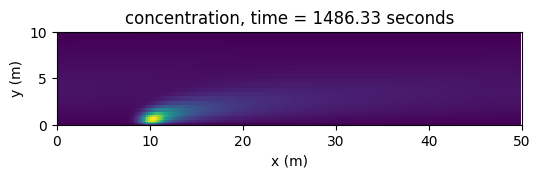

In [111]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)
    plt.ylim(0, w)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

**Timescale of Transport**

By scaling analysis of the governing equation, we can balance the time-dependent term ($\frac{\partial c}{\partial t}\sim \frac{c}{t}$) with the vertical diffusivity term ($\kappa\frac{\partial^2 c}{\partial y^2}\sim \frac{\kappa c}{w^2}$) to get a timescale for the transport of pollution across the river:

$$
t \sim \frac{w^2}{\kappa}
$$

If we then balance the advective term with the time-dependent term, substituting in this timescale, we find that the associated length scale (and thus the distance along the river we would expect to see pollution reaching the opposite side) is:

$$
L\sim Ut \sim \frac{Uw^2}{\kappa}
$$

Substituting in the numbers we have, we find that $t\approx 1\times 10^4$, while $L\approx 1000m$.

In order to see pollution at the opposite bank within the currently simulated timeframe, we could set $\kappa=0.1$ which would give $t\sim 1000s$ and a length scale of $L\sim 100m$.

**Simulation results**

We repeat the simulation below, changing parameters to see pollution reaching the opposing bank. We set:
- `κ` $= 0.1$
- `L` $=150m$
- `sim_stop_time` $=1500$

The simulation results seem to agree with our scaling analysis; although not at 100m downstream, we do see that the pollutant reaches the opposing bank at $(x, t) = (30, 300)$, validating our scaling analysis (with $L\sim Ut = 0.1 * t$), and $300s$ is within an order of magnitude of our estimated travel time of $1000s$ which also seems acceptable.

In [135]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 150 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 512 # number of gridpoints in x
Ny = 64 # number of gridpoints in y
stop_sim_time = 1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s


2025-11-11 16:13:41,819 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s


INFO:__main__:Starting main loop


2025-11-11 16:13:41,826 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=2.929688e+00, dt=2.929688e+00


2025-11-11 16:13:41,965 __main__ 0/1 INFO :: Iteration=1, Time=2.929688e+00, dt=2.929688e+00


INFO:__main__:Iteration=11, Time=3.222656e+01, dt=2.929688e+00


2025-11-11 16:13:42,048 __main__ 0/1 INFO :: Iteration=11, Time=3.222656e+01, dt=2.929688e+00


INFO:__main__:Iteration=21, Time=6.152344e+01, dt=2.929688e+00


2025-11-11 16:13:42,127 __main__ 0/1 INFO :: Iteration=21, Time=6.152344e+01, dt=2.929688e+00


INFO:__main__:Iteration=31, Time=9.082031e+01, dt=2.929688e+00


2025-11-11 16:13:42,210 __main__ 0/1 INFO :: Iteration=31, Time=9.082031e+01, dt=2.929688e+00


INFO:__main__:Iteration=41, Time=1.201172e+02, dt=2.929688e+00


2025-11-11 16:13:42,290 __main__ 0/1 INFO :: Iteration=41, Time=1.201172e+02, dt=2.929688e+00


INFO:__main__:Iteration=51, Time=1.494141e+02, dt=2.929688e+00


2025-11-11 16:13:42,368 __main__ 0/1 INFO :: Iteration=51, Time=1.494141e+02, dt=2.929688e+00


INFO:__main__:Iteration=61, Time=1.787109e+02, dt=2.929688e+00


2025-11-11 16:13:42,460 __main__ 0/1 INFO :: Iteration=61, Time=1.787109e+02, dt=2.929688e+00


INFO:__main__:Iteration=71, Time=2.080078e+02, dt=2.929688e+00


2025-11-11 16:13:42,539 __main__ 0/1 INFO :: Iteration=71, Time=2.080078e+02, dt=2.929688e+00


INFO:__main__:Iteration=81, Time=2.373047e+02, dt=2.929688e+00


2025-11-11 16:13:42,623 __main__ 0/1 INFO :: Iteration=81, Time=2.373047e+02, dt=2.929688e+00


INFO:__main__:Iteration=91, Time=2.666016e+02, dt=2.929688e+00


2025-11-11 16:13:42,703 __main__ 0/1 INFO :: Iteration=91, Time=2.666016e+02, dt=2.929688e+00


INFO:__main__:Iteration=101, Time=2.958984e+02, dt=2.929688e+00


2025-11-11 16:13:42,784 __main__ 0/1 INFO :: Iteration=101, Time=2.958984e+02, dt=2.929688e+00


INFO:__main__:Iteration=111, Time=3.251953e+02, dt=2.929688e+00


2025-11-11 16:13:42,865 __main__ 0/1 INFO :: Iteration=111, Time=3.251953e+02, dt=2.929688e+00


INFO:__main__:Iteration=121, Time=3.544922e+02, dt=2.929688e+00


2025-11-11 16:13:42,945 __main__ 0/1 INFO :: Iteration=121, Time=3.544922e+02, dt=2.929688e+00


INFO:__main__:Iteration=131, Time=3.837891e+02, dt=2.929688e+00


2025-11-11 16:13:43,032 __main__ 0/1 INFO :: Iteration=131, Time=3.837891e+02, dt=2.929688e+00


INFO:__main__:Iteration=141, Time=4.130859e+02, dt=2.929688e+00


2025-11-11 16:13:43,111 __main__ 0/1 INFO :: Iteration=141, Time=4.130859e+02, dt=2.929688e+00


INFO:__main__:Iteration=151, Time=4.423828e+02, dt=2.929688e+00


2025-11-11 16:13:43,194 __main__ 0/1 INFO :: Iteration=151, Time=4.423828e+02, dt=2.929688e+00


INFO:__main__:Iteration=161, Time=4.716797e+02, dt=2.929688e+00


2025-11-11 16:13:43,273 __main__ 0/1 INFO :: Iteration=161, Time=4.716797e+02, dt=2.929688e+00


INFO:__main__:Iteration=171, Time=5.009766e+02, dt=2.929688e+00


2025-11-11 16:13:43,354 __main__ 0/1 INFO :: Iteration=171, Time=5.009766e+02, dt=2.929688e+00


INFO:__main__:Iteration=181, Time=5.302734e+02, dt=2.929688e+00


2025-11-11 16:13:43,436 __main__ 0/1 INFO :: Iteration=181, Time=5.302734e+02, dt=2.929688e+00


INFO:__main__:Iteration=191, Time=5.595703e+02, dt=2.929688e+00


2025-11-11 16:13:43,530 __main__ 0/1 INFO :: Iteration=191, Time=5.595703e+02, dt=2.929688e+00


INFO:__main__:Iteration=201, Time=5.888672e+02, dt=2.929688e+00


2025-11-11 16:13:43,613 __main__ 0/1 INFO :: Iteration=201, Time=5.888672e+02, dt=2.929688e+00


INFO:__main__:Iteration=211, Time=6.181641e+02, dt=2.929688e+00


2025-11-11 16:13:43,691 __main__ 0/1 INFO :: Iteration=211, Time=6.181641e+02, dt=2.929688e+00


INFO:__main__:Iteration=221, Time=6.474609e+02, dt=2.929688e+00


2025-11-11 16:13:43,772 __main__ 0/1 INFO :: Iteration=221, Time=6.474609e+02, dt=2.929688e+00


INFO:__main__:Iteration=231, Time=6.767578e+02, dt=2.929688e+00


2025-11-11 16:13:43,855 __main__ 0/1 INFO :: Iteration=231, Time=6.767578e+02, dt=2.929688e+00


INFO:__main__:Iteration=241, Time=7.060547e+02, dt=2.929688e+00


2025-11-11 16:13:43,938 __main__ 0/1 INFO :: Iteration=241, Time=7.060547e+02, dt=2.929688e+00


INFO:__main__:Iteration=251, Time=7.353516e+02, dt=2.929688e+00


2025-11-11 16:13:44,026 __main__ 0/1 INFO :: Iteration=251, Time=7.353516e+02, dt=2.929688e+00


INFO:__main__:Iteration=261, Time=7.646484e+02, dt=2.929688e+00


2025-11-11 16:13:44,108 __main__ 0/1 INFO :: Iteration=261, Time=7.646484e+02, dt=2.929688e+00


INFO:__main__:Iteration=271, Time=7.939453e+02, dt=2.929688e+00


2025-11-11 16:13:44,189 __main__ 0/1 INFO :: Iteration=271, Time=7.939453e+02, dt=2.929688e+00


INFO:__main__:Iteration=281, Time=8.232422e+02, dt=2.929688e+00


2025-11-11 16:13:44,270 __main__ 0/1 INFO :: Iteration=281, Time=8.232422e+02, dt=2.929688e+00


INFO:__main__:Iteration=291, Time=8.525391e+02, dt=2.929688e+00


2025-11-11 16:13:44,345 __main__ 0/1 INFO :: Iteration=291, Time=8.525391e+02, dt=2.929688e+00


INFO:__main__:Iteration=301, Time=8.818359e+02, dt=2.929688e+00


2025-11-11 16:13:44,430 __main__ 0/1 INFO :: Iteration=301, Time=8.818359e+02, dt=2.929688e+00


INFO:__main__:Iteration=311, Time=9.111328e+02, dt=2.929688e+00


2025-11-11 16:13:44,519 __main__ 0/1 INFO :: Iteration=311, Time=9.111328e+02, dt=2.929688e+00


INFO:__main__:Iteration=321, Time=9.404297e+02, dt=2.929688e+00


2025-11-11 16:13:44,606 __main__ 0/1 INFO :: Iteration=321, Time=9.404297e+02, dt=2.929688e+00


INFO:__main__:Iteration=331, Time=9.697266e+02, dt=2.929688e+00


2025-11-11 16:13:44,686 __main__ 0/1 INFO :: Iteration=331, Time=9.697266e+02, dt=2.929688e+00


INFO:__main__:Iteration=341, Time=9.990234e+02, dt=2.929688e+00


2025-11-11 16:13:44,763 __main__ 0/1 INFO :: Iteration=341, Time=9.990234e+02, dt=2.929688e+00


INFO:__main__:Iteration=351, Time=1.028320e+03, dt=2.929688e+00


2025-11-11 16:13:44,844 __main__ 0/1 INFO :: Iteration=351, Time=1.028320e+03, dt=2.929688e+00


INFO:__main__:Iteration=361, Time=1.057617e+03, dt=2.929688e+00


2025-11-11 16:13:44,925 __main__ 0/1 INFO :: Iteration=361, Time=1.057617e+03, dt=2.929688e+00


INFO:__main__:Iteration=371, Time=1.086914e+03, dt=2.929688e+00


2025-11-11 16:13:45,009 __main__ 0/1 INFO :: Iteration=371, Time=1.086914e+03, dt=2.929688e+00


INFO:__main__:Iteration=381, Time=1.116211e+03, dt=2.929688e+00


2025-11-11 16:13:45,088 __main__ 0/1 INFO :: Iteration=381, Time=1.116211e+03, dt=2.929688e+00


INFO:__main__:Iteration=391, Time=1.145508e+03, dt=2.929688e+00


2025-11-11 16:13:45,164 __main__ 0/1 INFO :: Iteration=391, Time=1.145508e+03, dt=2.929688e+00


INFO:__main__:Iteration=401, Time=1.174805e+03, dt=2.929688e+00


2025-11-11 16:13:45,251 __main__ 0/1 INFO :: Iteration=401, Time=1.174805e+03, dt=2.929688e+00


INFO:__main__:Iteration=411, Time=1.204102e+03, dt=2.929688e+00


2025-11-11 16:13:45,330 __main__ 0/1 INFO :: Iteration=411, Time=1.204102e+03, dt=2.929688e+00


INFO:__main__:Iteration=421, Time=1.233398e+03, dt=2.929688e+00


2025-11-11 16:13:45,409 __main__ 0/1 INFO :: Iteration=421, Time=1.233398e+03, dt=2.929688e+00


INFO:__main__:Iteration=431, Time=1.262695e+03, dt=2.929688e+00


2025-11-11 16:13:45,487 __main__ 0/1 INFO :: Iteration=431, Time=1.262695e+03, dt=2.929688e+00


INFO:__main__:Iteration=441, Time=1.291992e+03, dt=2.929688e+00


2025-11-11 16:13:45,580 __main__ 0/1 INFO :: Iteration=441, Time=1.291992e+03, dt=2.929688e+00


INFO:__main__:Iteration=451, Time=1.321289e+03, dt=2.929688e+00


2025-11-11 16:13:45,660 __main__ 0/1 INFO :: Iteration=451, Time=1.321289e+03, dt=2.929688e+00


INFO:__main__:Iteration=461, Time=1.350586e+03, dt=2.929688e+00


2025-11-11 16:13:45,739 __main__ 0/1 INFO :: Iteration=461, Time=1.350586e+03, dt=2.929688e+00


INFO:__main__:Iteration=471, Time=1.379883e+03, dt=2.929688e+00


2025-11-11 16:13:45,819 __main__ 0/1 INFO :: Iteration=471, Time=1.379883e+03, dt=2.929688e+00


INFO:__main__:Iteration=481, Time=1.409180e+03, dt=2.929688e+00


2025-11-11 16:13:45,898 __main__ 0/1 INFO :: Iteration=481, Time=1.409180e+03, dt=2.929688e+00


INFO:__main__:Iteration=491, Time=1.438477e+03, dt=2.929688e+00


2025-11-11 16:13:45,980 __main__ 0/1 INFO :: Iteration=491, Time=1.438477e+03, dt=2.929688e+00


INFO:__main__:Iteration=501, Time=1.467773e+03, dt=2.929688e+00


2025-11-11 16:13:46,063 __main__ 0/1 INFO :: Iteration=501, Time=1.467773e+03, dt=2.929688e+00


INFO:__main__:Iteration=511, Time=1.497070e+03, dt=2.929688e+00


2025-11-11 16:13:46,142 __main__ 0/1 INFO :: Iteration=511, Time=1.497070e+03, dt=2.929688e+00


INFO:solvers:Simulation stop time reached.


2025-11-11 16:13:46,157 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 512


2025-11-11 16:13:46,160 solvers 0/1 INFO :: Final iteration: 512


INFO:solvers:Final sim time: 1500.0


2025-11-11 16:13:46,162 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.6445 sec


2025-11-11 16:13:46,165 solvers 0/1 INFO :: Setup time (init - iter 0): 0.6445 sec


INFO:solvers:Warmup time (iter 0-10): 0.2129 sec


2025-11-11 16:13:46,167 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.2129 sec


INFO:solvers:Run time (iter 10-end): 4.118 sec


2025-11-11 16:13:46,168 solvers 0/1 INFO :: Run time (iter 10-end): 4.118 sec


INFO:solvers:CPU time (iter 10-end): 0.001144 cpu-hr


2025-11-11 16:13:46,170 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001144 cpu-hr


INFO:solvers:Speed: 8.222e+06 mode-stages/cpu-sec


2025-11-11 16:13:46,175 solvers 0/1 INFO :: Speed: 8.222e+06 mode-stages/cpu-sec


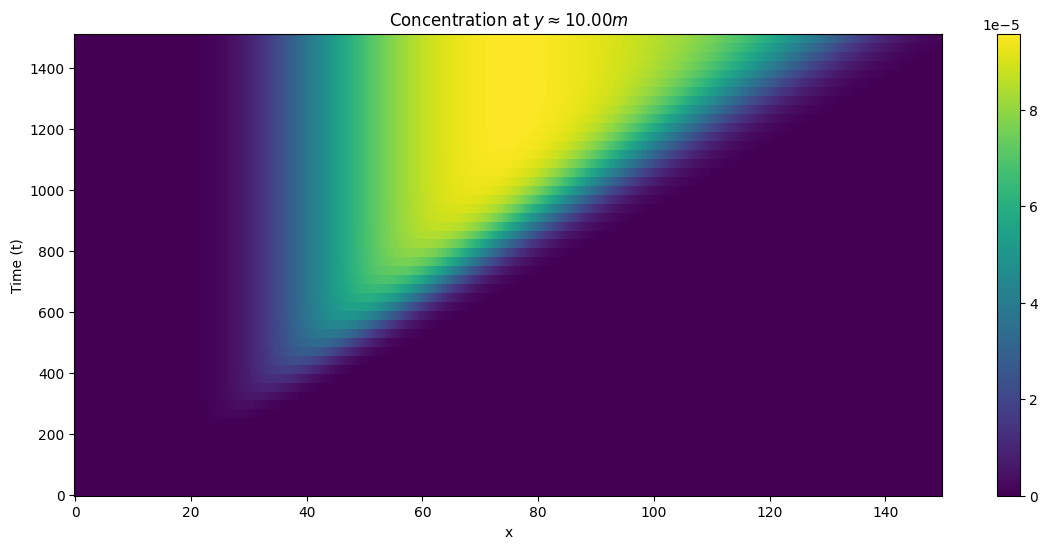

In [136]:
fig, axs = plt.subplots(1, 1, figsize = (14, 6))
c_vals = c_save[:, :, -1]

target = axs.pcolormesh(x.reshape(-1,), t_save, c_vals)
axs.set_ylabel('Time (t)')
axs.set_xlabel('x')
axs.set_title(f'Concentration at $y\\approx {y[0][-1]:.02f}m$')
plt.colorbar(target, ax = axs)

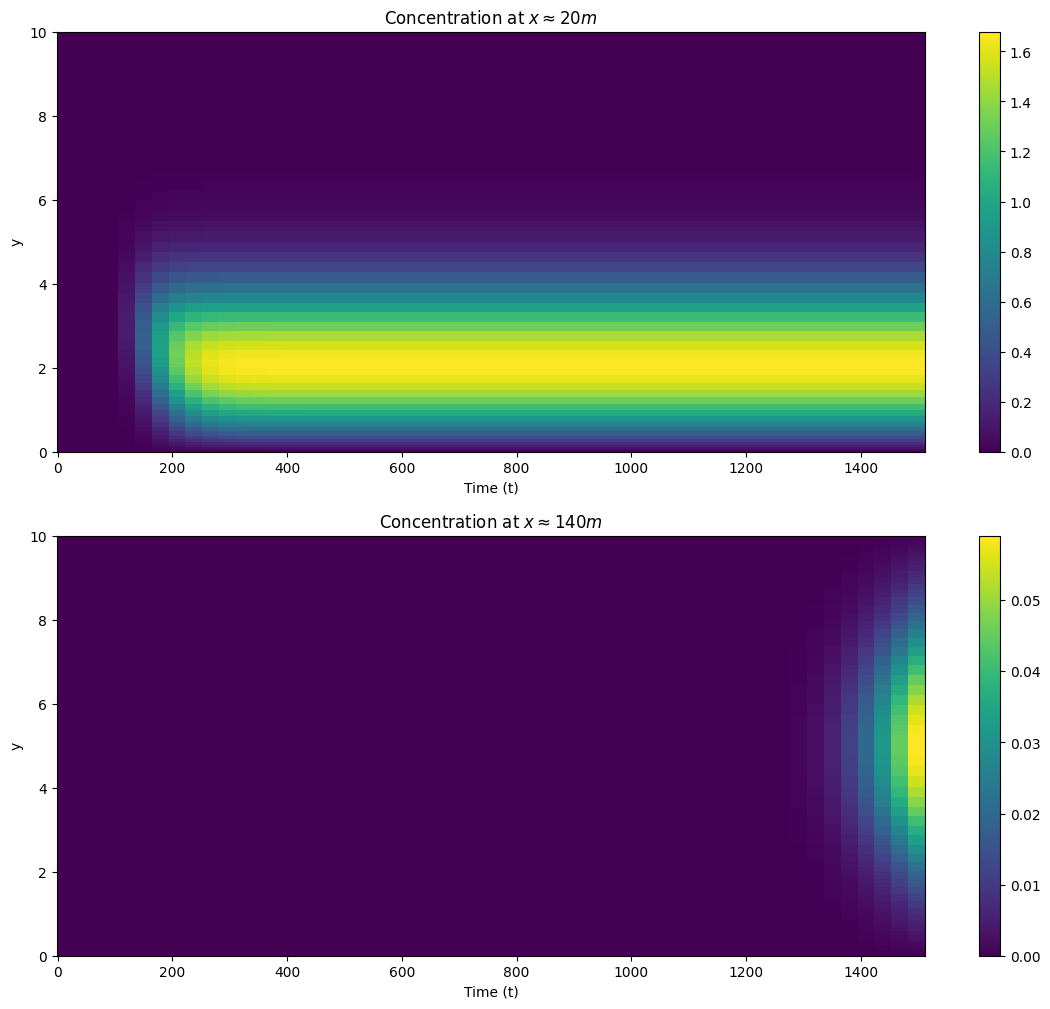

In [137]:
resolution = L / Nx

x_vals = [20, 140]
x_posns = [int(x_val // resolution) for x_val in x_vals]

fig, axs = plt.subplots(len(x_vals), 1, figsize = (14, 6*len(x_posns)))

for idx, x_posn in enumerate(x_posns):
  c_vals = c_save[:, x_posn, :]

  target = axs[idx].pcolormesh(t_save, y.reshape(-1,), c_vals.transpose())
  axs[idx].set_xlabel('Time (t)')
  axs[idx].set_ylabel('y')
  axs[idx].set_title(f'Concentration at $x\\approx {x_vals[idx]}m$')
  plt.colorbar(target, ax = axs[idx])

### Turbulent diffusion
In a turbulent flow, tracers will be transported by the turbulent eddies. A common way to model this is to introduce a turbulent diffusivity, $\kappa_T\sim u*l$, where $u$ and $l$ are characteristic velocity and length scales associated with the turbulent eddies.

To explore this effect, create a Dedalus script that includes advection by $u$ and $v$ (the $x$ and $y$ components of the velocity). Then, use the same velocity field as above for $u$ and add to that a fluctuating velocity field that of the form

$$ u=u_0 cos(kx)cos(ky), \quad v=u_0 sin(kx)sin(ky) $$

where $k$ is the wavenumber associated with the velocity fluctuations and $u_0$ is the amplitude of the fluctuations. Note that $k$ should be set to give an integer number of wavelengths in the $x$ and $y$ directions. Vary both $u_0$ and $k$ and study how quicky the tracer is transported across the river. Qualitatively compare this with the expectation based on the hypothesis of turbulent diffusion.

**Comments on Code**

After adding a term representing advection by $v$, our governing equation will now be:

$$
\frac{\partial c}{\partial t} + u(x, y)\frac{\partial c}{\partial x} + v(x, y)\frac{\partial c}{\partial y} = \kappa \nabla^2 c + S(x,y)
$$

noting that $u$ and $v$ are now functions of both $x$ and $y$.

*Choosing $k$*

Noting that the wavelength is $\lambda = 1/k$, we need to choose $k$ such that $\lambda$ divides both the x- and y- extent, which in this case are 50 and 10 respectively. It thus suffices to choose $\lambda$ that divides 10.

**Results**

We see that we get pollution at around $(x, t)=(30, 300)$

In [147]:
"""
Solving time-dependent a/d equation with turbulence
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 100 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

## Fluctuation parameters
u_0 = 0.01
lam = 5 ## lambda
k = 2*np.pi / lam

# Numerical parameters
Nx = 512 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
v = dist.Field(name='v', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1 - (y - w/2)**2.0 / (w/2)**2.0) + u_0 * np.cos(k*x) * np.cos(k*y)
v['g'] = u_0 * np.sin(k*x) * np.sin(k*y)

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) + v*dy(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 6.9e-01/s


2025-11-11 16:30:04,590 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 6.9e-01/s


INFO:__main__:Starting main loop


2025-11-11 16:30:04,597 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-11 16:30:05,071 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-11 16:30:05,247 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-11 16:30:05,411 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-11 16:30:05,579 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-11 16:30:05,746 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-11 16:30:05,910 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-11 16:30:06,073 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-11 16:30:06,254 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-11 16:30:06,419 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-11 16:30:06,584 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-11 16:30:06,751 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-11 16:30:06,917 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-11 16:30:07,083 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-11 16:30:07,266 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-11 16:30:07,450 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-11 16:30:07,617 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-11 16:30:07,782 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-11 16:30:07,948 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-11 16:30:08,113 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-11 16:30:08,288 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-11 16:30:08,455 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-11 16:30:08,619 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-11 16:30:08,784 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-11 16:30:08,951 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-11 16:30:09,119 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-11 16:30:09,295 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-11 16:30:09,462 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-11 16:30:09,628 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-11 16:30:09,796 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-11 16:30:09,964 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-11 16:30:10,131 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-11 16:30:10,306 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-11 16:30:10,480 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-11 16:30:10,644 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-11 16:30:10,813 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-11 16:30:10,984 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-11 16:30:11,157 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-11 16:30:11,333 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-11 16:30:11,506 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-11 16:30:11,671 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-11 16:30:11,858 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-11 16:30:12,089 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-11 16:30:12,321 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-11 16:30:12,553 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-11 16:30:12,777 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-11 16:30:13,001 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-11 16:30:13,213 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-11 16:30:13,440 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-11 16:30:13,658 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-11 16:30:13,889 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-11 16:30:14,128 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-11 16:30:14,364 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-11 16:30:14,599 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-11 16:30:14,793 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-11 16:30:14,962 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-11 16:30:15,135 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-11 16:30:15,310 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-11 16:30:15,478 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-11 16:30:15,654 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-11 16:30:15,822 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-11 16:30:15,990 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-11 16:30:16,161 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-11 16:30:16,337 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-11 16:30:16,507 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-11 16:30:16,685 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-11 16:30:16,856 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-11 16:30:17,029 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-11 16:30:17,198 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-11 16:30:17,369 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-11 16:30:17,536 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-11 16:30:17,719 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-11 16:30:17,885 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-11 16:30:18,054 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-11 16:30:18,226 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-11 16:30:18,394 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-11 16:30:18,560 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-11 16:30:18,738 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-11 16:30:18,854 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-11 16:30:18,856 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-11 16:30:18,861 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 1.587 sec


2025-11-11 16:30:18,867 solvers 0/1 INFO :: Setup time (init - iter 0): 1.587 sec


INFO:solvers:Warmup time (iter 0-10): 0.6327 sec


2025-11-11 16:30:18,870 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.6327 sec


INFO:solvers:Run time (iter 10-end): 13.62 sec


2025-11-11 16:30:18,873 solvers 0/1 INFO :: Run time (iter 10-end): 13.62 sec


INFO:solvers:CPU time (iter 10-end): 0.003785 cpu-hr


2025-11-11 16:30:18,879 solvers 0/1 INFO :: CPU time (iter 10-end): 0.003785 cpu-hr


INFO:solvers:Speed: 1.933e+06 mode-stages/cpu-sec


2025-11-11 16:30:18,881 solvers 0/1 INFO :: Speed: 1.933e+06 mode-stages/cpu-sec


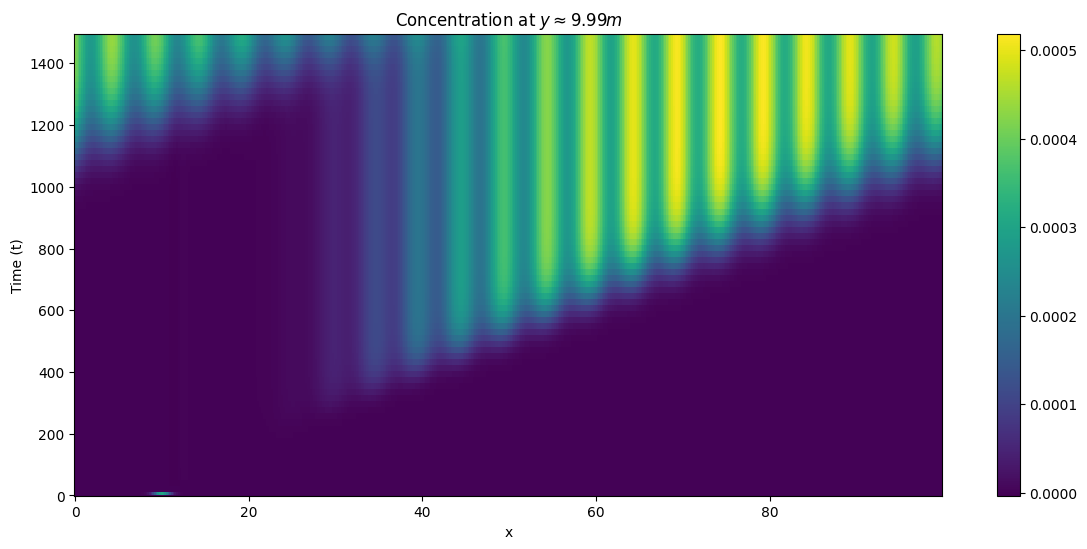

In [148]:
fig, axs = plt.subplots(1, 1, figsize = (14, 6))
c_vals = c_save[:, :, -1]

target = axs.pcolormesh(x.reshape(-1,), t_save, c_vals)
axs.set_ylabel('Time (t)')
axs.set_xlabel('x')
axs.set_title(f'Concentration at $y\\approx {y[0][-1]:.02f}m$')
plt.colorbar(target, ax = axs)

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-11 14:51:44,926 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp2p3nph8n/temp.m4v


2025-11-11 14:51:44,928 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp2p3nph8n/temp.m4v


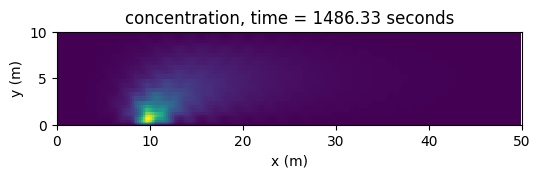

In [21]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)
    plt.ylim(0, w)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

## 3. Optional further investigations

* In the river pollution example, you might notice that the concentration field is mixed more effectively in the x-direction than in the y-direction. The combination of differential advection by the currents and cross-stream diffusion is very effective at mixing the plume in the x-direction. This is an example of Taylor dispersion (Taylor, 1953). Construct numerical experiments to quantify Taylor dispersion and its dependence on the current shear and the diffusivity. You could also separate the diffusivity into parts in the x and y directions with different coefficients.  If you set the x-component of the diffusivity to zero, then any spreading of the concentration in the x-direction should be due to Taylor dispersion.

* Try making the river speed a function of time. The easiest way to do this is to add a new equation so that Dedalus solves for the velocity in addition to the concentration field. For example, you could make the river speed decrease exponentially in time, or it could be sinusoidal in time.

* In the ocean mixing example, if $\kappa$ is a function of $x$ and $z$, what would this imply about the velocity field? You could even try writing a Dedalus script to solve the 2D advection/diffusion equation with a prescribed spatially-dependent $\kappa(x,z)$.


### References

Munk, W.H., 1966. Abyssal recipes. In Deep sea research and oceanographic abstracts (Vol. 13, No. 4, pp. 707-730). Elsevier.

Ferrari, R., Mashayek, A., McDougall, T.J., Nikurashin, M. and Campin, J.M., 2016. Turning ocean mixing upside down. Journal of Physical Oceanography, 46(7), pp.2239-2261.

Taylor, G.I., 1953. Dispersion of soluble matter in solvent flowing slowly through a tube. Proceedings of the Royal Society of London. Series A. Mathematical and Physical Sciences, 219(1137), pp.186-203.